## Kimi-VL-A3B

* From moonshot.ai
* Rank #28 in OpenCompass multimodal academic leaderboard for open-source models (https://rank.opencompass.org.cn/leaderboard-multimodal)

In [29]:
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor
import requests
import io
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode


model_path = '/data/students/earl/llava-dissector/Kimi-VL-A3B-Instruct'
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto",
    do_sample=False,
    trust_remote_code=True,
)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)


# helper functions

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=10, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    # Check if image_file is a URL
    if isinstance(image_file, str) and (image_file.startswith('http://') or image_file.startswith('https://')):
        response = requests.get(image_file)
        image = Image.open(io.BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values


Loading checkpoint shards: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


{'bounding_box': [0.380, 0.681, 0.420, 0.758], 'category': 'baseball_glove'}, {'bounding_box': [0.720, 0.523, 0.740, 0.541], 'category': 'baseball_glove'}, {'bounding_box': [0.760, 0.523, 0.770, 0.541], 'category': 'baseball_glove'}, {'bounding_box': [0.870, 0.489, 0.880, 0.507], 'category': 'baseball_glove'}
Bounding Boxes: [[0.38, 0.681, 0.42, 0.758], [0.72, 0.523, 0.74, 0.541], [0.76, 0.523, 0.77, 0.541], [0.87, 0.489, 0.88, 0.507]]


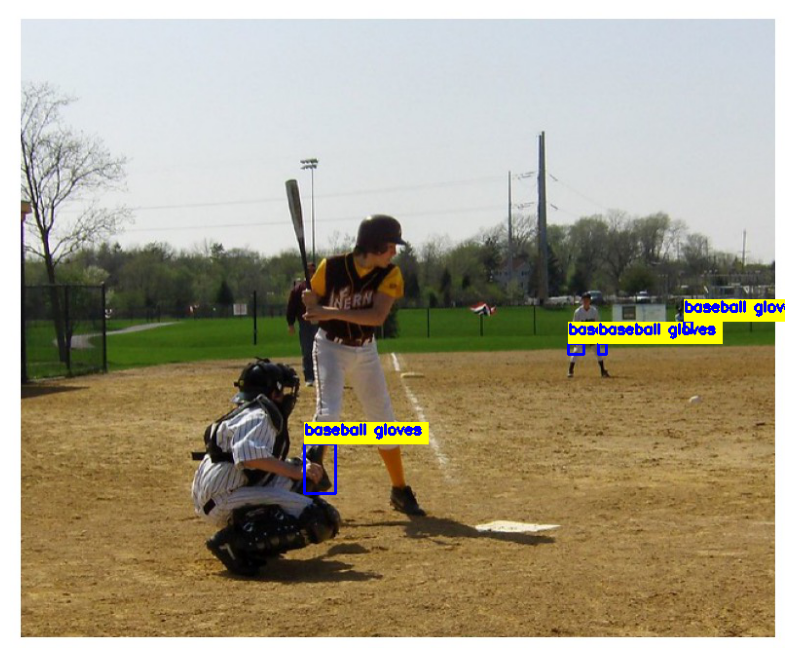

In [46]:
import cv2
import io
import re
import requests
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

cls = "baseball gloves"
model.threshold = -1.5

#image_path = url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg"
image_path = url = "/data/students/earl/llava-dissector/rca/assets/game_at_the_park.jpg"

text = f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image.'

#image = load_image(url) #Image.open(image_path)
#image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
if isinstance(url, str) and (url.startswith('http://') or url.startswith('https://')):
    # If the URL is a string, fetch the image from the URL
    image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
else:
    # If it's a local file path, open the image directly
    image = Image.open(url).convert("RGB")

messages = [
    {"role": "user", "content": 
        [{"type": "image", "image": image_path}, 
         {"type": "text", "text": {text}}
        ]
    }
]
text = processor.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
inputs = processor(images=image, text=text, return_tensors="pt", padding=True, truncation=True).to(model.device)
generated_ids = model.generate(**inputs, max_new_tokens=512)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
response = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(response)

# regex the part of string to extract bounding boxes
pattern = r'(?:[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*[\]\)])|(?:<box>\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*</box>)'
matches = re.findall(pattern, response)
bounding_boxes = []
for match in matches:
    # Each match is a tuple of 8 elements, only 4 will be filled
    coords = [c for c in match if c != '']
    if len(coords) == 4:
        bounding_boxes.append([float(c) for c in coords])
print(f'Bounding Boxes: {bounding_boxes}')

# Visualize using cv2
# Load the original image for visualization
if isinstance(url, str) and (url.startswith('http://') or url.startswith('https://')):
    image_from_url = requests.get(url)
    orig_img = Image.open(io.BytesIO(image_from_url.content)).convert('RGB')
else:
    orig_img = Image.open(url).convert('RGB')
img_cv = np.array(orig_img)  # HWC, RGB
for box in bounding_boxes:
    x1, y1, x2, y2 = box
    # convert these normalized coordinates to pixel values
    h, w, _ = img_cv.shape
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 0, 255), 2)
    (text_width, text_height), _ = cv2.getTextSize(cls, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
    box_coords = ((x1, y1), (x1 + text_width + 5, y1 -10 - text_height))
    cv2.rectangle(img_cv, box_coords[0], box_coords[1], (255,255,0), cv2.FILLED)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 
